# Recurrent Neural Networks

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>
Updates by G.Durantin, 2021\
Gautier Durantin, gautier.durantin@e-i.com

In this class, we'll cover a new type of deep neural network layer: recurrent layers. These layer types share the common feature of having internal or **hidden state**. This makes them well-suited to sequential data, such as time series or text data. They are heavily used in Natural Language Processing, the subject of [the next class](https://supaerodatascience.github.io/deep-learning/NLP.html). 

In [2]:
%pip install pyedflib

     |████████████████████████████████| 1.7 MB 5.3 MB/s 


In [3]:
import os
import pyedflib
import numpy as np
import random as rd
import string
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

NLP - chatbox\
We need to extract the following infos: 
- an intention
- a named entity

Example:
- qu'est-ce qui passe avec ma CB?\
intention: info on payment means\
named entity: payment means (CB)

## Introductory activity : *Finding Structure in Time* (Elman, 1990)

In his fundational work on Recurrent Neural Networks, Elman looked at a variety of problems that could not be solved using "standard" Neural Networks.
The common feature of these problems, presented in his paper coined *Finding Structure in Time* (published in 1990), is that the data underlying them has structure in time (e.g. it has some sort of periodicity, or is organisez as a sequence).

Here we propose to reproduce an adaptation of one of these problems, looking at **learning word boundaries**

### 1. Problem : *Le Heron* (La Fontaine, 1678)

In his paper, Elman worked with a lexicon composed of 15 english words. In this exercice, we will use French words instead, and use the first 16 words encountered in *Le Héron* (La Fontaine, 1678).

<div align="center"><b>Un jour sur ses longs pieds, allait, je ne sais où,<br/>
Le Héron au long bec </b> emmanché d'un long cou.<br/>
Il côtoyait une rivière.</div>

Using these 16 words, we generate plenty of sentences by randomly sampling from the lexicon.

In [4]:
#lexicon
lexicon=["un","jour","sur","ses","longs","pieds","allait","je","ne","sais","ou","le","heron","au","long","bec"]

#generate sentences
def generateSentence(lexicon,n_words):
    return ''.join(rd.sample(lexicon,n_words))

text=''.join(lexicon)
for n_sentences in range(150):
    text+=generateSentence(lexicon,rd.randrange(11,16))

print("text length (number of characters):",len(text),"\n",text[0:1000])

text length (number of characters): 6712 
 unjoursurseslongspiedsallaitjenesaisouleheronaulongbecseslongsunlongaubecallaitsaispiedssurnelejeoujeleallaitsesoulongunjourausaisnepiedsheronsuraunesaissurbecunjelongspiedsoujourleheronpiedsauseslongallaitsursaisoujournejelebeclongsunoulelongjesuraunesaisallaitjourlongspiedssesouallaitheronlongsaisaubecjenejourunlongsoulongbecallaitsurlepiedsaunejourheronsaisunlongsjeheronsesjourbecoulongpiedslongsunauleallaitnesaissurjeunnesaisjourheronpiedsbecouleausurlongsesallaitallaitsurpiedsunsesbecauouheronsaislongsjejourlonglongsheronsurouaupiedsneallaitjejourunsaislongsesbecunjourpiedslongsjeouleausaisbecleauheronousesjelongneallaitsursurpiedssesallaitnesaisbecheronoujourlongsaulongjejebeclongneallaitjourheronunleauousaisheronjepiedssursesneauleunoujourlongslongallaitbecheronsaisleaunelongunjelongssesjourallaitsuroulongallaitsurlongsoupiedssessaisheronlejeauheronoupiedslongsallaitsurbecseslonglesaislongallaitjelongsheronneunsaissuroubecjeouheronallai

As you will notice, the text has been preprocessed (removal of all punctuation, accents, etc...), and all the words and sentences have been appended. **What remains is a long sequence of characters, with no word boundaries remaining**.

### 2. Data preparation and task Definition

To work with pyTorch, we need to organize data in tensors. 
Each character in the text is one of the 26 letters of the alphabets. Therefore, *5 bits* are enough to encode each of the characters.

The task Elman proposes to focus on for this problem is **predicting the next character of the sequence**. Performing well at this task would mean that the network has managed to understand that sequences of characters form words, and are therefore predictable.
To implement the task in pyTorch, we need to create 2 tensors : one defining the $input$ that will be given to the network (i.e the current character), and the $target$ (i.e. the following character)



In [5]:
# Convert a character into a 5 bits encoding
def encodeCharacter(char):
    index=string.ascii_lowercase.index(char) #Index in the alphabet l'alphabet du caractère
    output = [float(x) for x in '{:05b}'.format(index)] #convert to 5 bits
    return output 

# Encode sequence
input=[]
target=[]
for i in range(len(text)-1):
    input.append(encodeCharacter(text[i]))
    target.append(encodeCharacter(text[i+1]))
#convert to tensors
input=torch.from_numpy(np.array(input))
target=torch.from_numpy(np.array(target))

print("tensors size :", input.size())
print("first input : ", input[0])
print("first target : ", target[0])

tensors size : torch.Size([6711, 5])
first input :  tensor([1., 0., 1., 0., 0.], dtype=torch.float64)
first target :  tensor([0., 1., 1., 0., 1.], dtype=torch.float64)


### 3. Simple approach : ANN with one hidden layer

As a first approach and a baseline, we propose to look at how well a network with one hidden layer would perform.

In [6]:
class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearNN, self).__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sig=nn.Sigmoid()

    def forward(self, input):
        hidden = self.linear1(input)
        output = self.sig(self.linear2(hidden))
        return output

To implement train the network, we will use the same parameters as what Elman proposes in his paper : 
- input and output layers of size 5 (corresponding to the encoding size of the letters)
- hidden layer of size 20
- training consisting of 10 complete iterations over the sequence.

In [7]:
n_hidden = 20
#network initialization
linearnn = LinearNN(5, n_hidden, 5).double()

#criterion and optimizer for training
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linearnn.parameters(), lr=0.1, momentum=0.9)

#training iterations
for iter in range(10):
    running_loss=0
    for char in range(input.size(0)) :
        optimizer.zero_grad()
        output = linearnn(input[char].reshape(1,5))
        loss = criterion(output, target[char].reshape(1,5))
        loss.backward(retain_graph=True)
        running_loss+=loss.item()
        optimizer.step()
    print("iter ",str(iter)," average loss on iteration :",str(running_loss/input.size(0)))

iter  0  average loss on iteration : 0.22574822776929762
iter  1  average loss on iteration : 0.22531348970966023
iter  2  average loss on iteration : 0.22530589303023638
iter  3  average loss on iteration : 0.2253023789249236
iter  4  average loss on iteration : 0.22530046636960044
iter  5  average loss on iteration : 0.22529927302487104
iter  6  average loss on iteration : 0.2252984628997443
iter  7  average loss on iteration : 0.2252978808628684
iter  8  average loss on iteration : 0.22529744541215155
iter  9  average loss on iteration : 0.22529710963469352


Looking at the loss, the network does not seem to have learned much. Let's look at a portion of the error when trying to use the network.\
The task is not exactly feasible (multiple combinations exist) so loss cannot attain 0 and pic at beginning of new word is normal while in longer words, when progressing in word loss should decline.

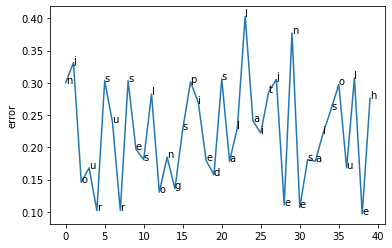

In [8]:
losses=np.empty(1)
with torch.no_grad():
    for i in range(input.size(0)) :
        output = linearnn(input[i].reshape(1,5))
        losses=np.append(losses,criterion(output, target[i].reshape(1,5)).detach().numpy())
        
max_char=40
offset=1
#ERROR PLOT
plt.plot(losses[offset:max_char+offset])
plt.ylabel('error')
for i in range(max_char):
    plt.text(i,losses[i+offset],text[i+offset]) #print the target letter for each step
plt.show()

Although the graph should look disappointing, there may be a pattern that start to emerge here : you may notice that the error is higher at the beginning of words. We will come back to this interpretation later.

However, it is clear that the network performs badly at learning to predict the next letter from the current one. Elman's interpretation of this result is that one fundamental aspect missing from the implementation : **recurrence**.

In fact, when predicting the next letter from the current one, it may be useful to keep in memory what the network predicted before. This memory enables the network to not only take into account its current state when predicting the outcome, but also to take into account the previous state.
For data organized in logically structured sequences (e.g. words), the concept of recurrence is crucial for good results.

### 4. Introducing recurrence

Elman's proposition is to add a **recurrent layer**. At each step, the hidden layer receives input not only from the input layer, but also from the recurrent layer. The state of the hidden layer is then copied into the recurrent layer for the next step.
This allows the network to keep some memory of the previous state.

<img src="img/elman.png">

*Note : Elman was not the first to propose this implementation. Jordan (1986) had already implemented recurrence, but had proposed to keep in memory the state of the output layer instead of the hidden layer*

Let's modify our network to introduce Elman's recurrence. In pyTorch, this can be done using the **RNNCell** layer.

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.sig=nn.Sigmoid()

    def forward(self, input, hidden):
        hidden = self.rnn1(input, hidden) # hidden(n-1) is also an input of the hidden(n)
        output = self.sig(self.linear(hidden))
        return output, hidden #we return both output and hidden state, as both will be needed for the next step
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, dtype=torch.double)

**Note : as you can see, in pyTorch, recurrence means that the hidden state is kept in memory through iterations**. That means that the forward method takes this recurrent state as an argument, and returns the updated state.
For the first step, the network's recurrent state will need to be initialized (here with zeros). The method init_hidden enables to do so.

In [10]:
n_hidden = 20
#network initialization
rnn = RNN(5, n_hidden, 5).double()

#criterion and optimizer for training
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.1, momentum=0.9)

#training iterations
for iter in range(10):
    running_loss=0
    hidden=rnn.init_hidden() #initialize hidden state
    for i in range(input.size(0)) :
        optimizer.zero_grad()
        output, hidden = rnn(input[i].reshape(1,5),hidden.detach())
        loss = criterion(output, target[i].reshape(1,5))
        loss.backward(retain_graph=True)
        running_loss+=loss.item()
        optimizer.step()
    print("iter ",str(iter)," average loss on iteration :",str(running_loss/input.size(0)))

iter  0  average loss on iteration : 0.21470265075643227
iter  1  average loss on iteration : 0.20120057596968022
iter  2  average loss on iteration : 0.1935831015679354
iter  3  average loss on iteration : 0.18516001708875424
iter  4  average loss on iteration : 0.17772733867057608
iter  5  average loss on iteration : 0.16677359013789606
iter  6  average loss on iteration : 0.173385491199521
iter  7  average loss on iteration : 0.16816994054883225
iter  8  average loss on iteration : 0.16739231960451986
iter  9  average loss on iteration : 0.16340917950449343


You should notice some convergence, even if not very convincing (as the task remains hard). Now, let's plot the error as we did with the standard ANN.

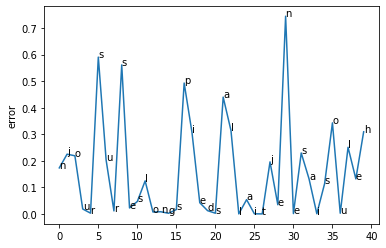

In [11]:
losses=np.empty(1)
with torch.no_grad():
    hidden=rnn.init_hidden() #initialize hidden state
    for i in range(input.size(0)) :
        output,hidden = rnn(input[i].reshape(1,5),hidden)
        losses=np.append(losses,criterion(output, target[i].reshape(1,5)).detach().numpy())
        
max_char=40
offset=1
#ERROR PLOT
plt.plot(losses[offset:max_char+offset])
plt.ylabel('error')
for i in range(max_char):
    plt.text(i,losses[i+offset],text[i+offset]) #print the target letter for each step
plt.show()

The pattern we started to see previously should appear very clearly now : the error is high at the beginning of words, and then decreases as the word becomes clearer. 

The RNN has difficulty with accords especially if there is the two words (singular and plural) in the lexicon.

This corresponds quite well with the way a human would solve this problem : *predicting the next letter from the current one is impossible, unless there is some structure (imposed by words) in this sequence*.
For instance, when just given the letter "h", there is no way for you to predict the next letter efficiently. However, as you continue reading, and manage to remember that the first letters are "*hero*", it is much more likely for you to predict the next letter to be "n" (to form the word "*heron*").

**In practice, our Recurrent Neural network has managed to learn the structure of words.**